Let us look at how we can implement text classification with Tensorflow https://www.tensorflow.org/
TensorFlow is an end-to-end open source platform for machine learning. 
The dataset is from the Tweet Sentiment Extraction challenge from Kaggle(https://www.kaggle.com/c/tweet-sentiment-extraction/overview)
We would implement text classification using a simple convolutional network developed using Tensorflow on tweet data to classify tweets as "positive","negative" or "neutral"

In [1]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf
from tensorflow.keras import regularizers

from tensorflow.keras import layers
from tensorflow.keras import losses

from collections import Counter


import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from tensorflow.keras import preprocessing
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences




import pydot

In [2]:
print(tf.__version__)
#policy = mixed_precision.Policy('mixed_float16')
#mixed_precision.set_policy(policy)

2.1.0


In [3]:
if tf.test.gpu_device_name(): 
    print('Default GPU Device:{}'.format(tf.test.gpu_device_name()))

else:
    print("Please install GPU version of TF")

Default GPU Device:/device:GPU:0


Let us define methods to pre-process the tweets

In [4]:
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def remove_url(text): 
    url_pattern  = re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    return url_pattern.sub(r'', text)
 # converting return value from list to string



def clean_text(text ): 
    delete_dict = {sp_character: '' for sp_character in string.punctuation} 
    delete_dict[' '] = ' ' 
    table = str.maketrans(delete_dict)
    text1 = text.translate(table)
    #print('cleaned:'+text1)
    textArr= text1.split()
    text2 = ' '.join([w for w in textArr if ( not w.isdigit() and  ( not w.isdigit() and len(w)>2))]) 
    
    return text2.lower()



In [ ]:
Let us pre-process the data

In [5]:
train_data= pd.read_csv("C:\\TweetSenitment\\train.csv")
train_data.dropna(axis = 0, how ='any',inplace=True) 
train_data['Num_words_text'] = train_data['text'].apply(lambda x:len(str(x).split())) 
mask = train_data['Num_words_text'] >2
train_data = train_data[mask]
print('-------Train data--------')
print(train_data['sentiment'].value_counts())
print(len(train_data))
print('-------------------------')
max_train_sentence_length  = train_data['Num_words_text'].max()


train_data['text'] = train_data['text'].apply(remove_emoji)
train_data['text'] = train_data['text'].apply(remove_url)
train_data['text'] = train_data['text'].apply(clean_text)


test_data= pd.read_csv("C:\\TweetSenitment\\test.csv")
test_data.dropna(axis = 0, how ='any',inplace=True) 
test_data['Num_words_text'] = test_data['text'].apply(lambda x:len(str(x).split())) 

max_test_sentence_length  = test_data['Num_words_text'].max()

mask = test_data['Num_words_text'] >2
test_data = test_data[mask]

print('-------Test data--------')
print(test_data['sentiment'].value_counts())
print(len(test_data))
print('-------------------------')

test_data['text'] = test_data['text'].apply(remove_emoji)
test_data['text'] = test_data['text'].apply(remove_url)
test_data['text'] = test_data['text'].apply(clean_text)


print('Train Max Sentence Length :'+str(max_train_sentence_length))
print('Test Max Sentence Length :'+str(max_test_sentence_length))

#all_sentences = train_data['text'].tolist() + test_data['text'].tolist()


-------Train data--------
neutral     10704
positive     8375
negative     7673
Name: sentiment, dtype: int64
26752
-------------------------
-------Test data--------
neutral     1376
positive    1075
negative     983
Name: sentiment, dtype: int64
3434
-------------------------
Train Max Sentence Length :33
Test Max Sentence Length :32


Let us split the training data into train and validation datasets
Let us convert our training,validation and test data into the format accepted by tensorflow

***
https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer
<br>
This class allows to vectorize a text corpus, by turning each text into either a sequence of integers (each integer being the index of a token in a dictionary) or into a vector where the coefficient for each token could be binary, based on word count, based on tf-idf...
***

In [22]:
num_words = 20000

tokenizer = Tokenizer(num_words=num_words,oov_token="unk")
tokenizer.fit_on_texts(train_data['text'].tolist())


print(str(tokenizer.texts_to_sequences(['xyz how are you'])))

   


[[1, 58, 21, 4]]


In [23]:
X_train, X_valid, y_train, y_valid = train_test_split(train_data['text'].tolist(),\
                                                      train_data['sentiment'].tolist(),\
                                                      test_size=0.1,\
                                                      stratify = train_data['sentiment'].tolist(),\
                                                      random_state=0)


print('Train data len:'+str(len(X_train)))
print('Class distribution'+str(Counter(y_train)))
print('Valid data len:'+str(len(X_valid)))
print('Class distribution'+ str(Counter(y_valid)))


x_train = np.array( tokenizer.texts_to_sequences(X_train) )
x_valid = np.array( tokenizer.texts_to_sequences(X_valid) )
x_test  = np.array( tokenizer.texts_to_sequences(test_data['text'].tolist()) )



x_train = pad_sequences(x_train, padding='post', maxlen=40)
x_valid = pad_sequences(x_valid, padding='post', maxlen=40)
x_test = pad_sequences(x_test, padding='post', maxlen=40)

print(x_train[0])

le = LabelEncoder()

train_labels = le.fit_transform(y_train)
train_labels = np.asarray( tf.keras.utils.to_categorical(train_labels))
#print(train_labels)
valid_labels = le.transform(y_valid)
valid_labels = np.asarray( tf.keras.utils.to_categorical(valid_labels))

test_labels = le.transform(test_data['sentiment'].tolist())
test_labels = np.asarray(tf.keras.utils.to_categorical(test_labels))
list(le.classes_)


train_ds = tf.data.Dataset.from_tensor_slices((x_train,train_labels))
valid_ds = tf.data.Dataset.from_tensor_slices((x_valid,valid_labels))
test_ds = tf.data.Dataset.from_tensor_slices((x_test,test_labels))


Train data len:24076
Class distributionCounter({'neutral': 9633, 'positive': 7537, 'negative': 6906})
Valid data len:2676
Class distributionCounter({'neutral': 1071, 'positive': 838, 'negative': 767})


d:\tensorflow\tf\lib\site-packages\ipykernel_launcher.py:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
d:\tensorflow\tf\lib\site-packages\ipykernel_launcher.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  from ipykernel import kernelapp as app
d:\tensorflow\tf\lib\site-packages\ipykernel_launcher.py:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when

[  23    4    9   25    2    1   24  823  158    1  173    1 8795 6293
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0]


In [24]:
print(y_train[:10])
train_labels = le.fit_transform(y_train)
print('Text to number')
print(train_labels[:10])
train_labels = np.asarray( tf.keras.utils.to_categorical(train_labels))
print('Number to category')
print(train_labels[:10])

['positive', 'positive', 'neutral', 'negative', 'neutral', 'negative', 'positive', 'positive', 'positive', 'neutral']
Text to number
[2 2 1 0 1 0 2 2 2 1]
Number to category
[[0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]]


In [9]:
count =0
print('======Train dataset ====')
for value,label in train_ds:
    count += 1
    print(value,label)
    if count==3:
        break
count =0
print('======Validation dataset ====')
for value,label in valid_ds:
    count += 1
    print(value,label)
    if count==3:
        break
print('======Test dataset ====')
for value,label in test_ds:
    count += 1
    print(value,label)
    if count==3:
        break  

======Train dataset ====
tf.Tensor(
[  22    3    8   24    1   23  822  157  172 8794 6292    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0], shape=(40,), dtype=int32) tf.Tensor([0. 0. 1.], shape=(3,), dtype=float32)
tf.Tensor(
[3597    1 2099  123  556   20  542   17  100    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0], shape=(40,), dtype=int32) tf.Tensor([0. 0. 1.], shape=(3,), dtype=float32)
tf.Tensor(
[ 116 4680    2  270   18 3692   89    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0], shape=(40,), dtype=int32) tf.Tensor([0. 1. 0.], shape=(3,), dtype=float32)
======Validation dataset ====
tf.Tensor(
[  188    93    19  1511   103     6   473    13   422   294 

    0    0    0    0    0    0    0    0    0    0    0    0], shape=(40,), dtype=int32) tf.Tensor([0. 1. 0.], shape=(3,), dtype=float32)
tf.Tensor(
[ 106    8 2773   31    1 5304  179    6    5  230  461   61    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0], shape=(40,), dtype=int32) tf.Tensor([1. 0. 0.], shape=(3,), dtype=float32)
tf.Tensor(
[189   7   3 210   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0], shape=(40,), dtype=int32) tf.Tensor([0. 1. 0.], shape=(3,), dtype=float32)
tf.Tensor(
[4024    9  131  203 1799  351  645  169 2291 3749    1    2 6120   16
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0], shape=(40,), dtype=int32) tf.Tensor([0. 0. 1.], shape=(3,), dtype=float32)
tf.Tensor(
[    8   530    48

tf.Tensor(
[   5   12 1768    4  119   63  106   72  126   75  100 2989   13  123
  898   28    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0], shape=(40,), dtype=int32) tf.Tensor([0. 1. 0.], shape=(3,), dtype=float32)
tf.Tensor(
[ 750 2580 1511   20  528  391  124   15  395   30    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0], shape=(40,), dtype=int32) tf.Tensor([0. 1. 0.], shape=(3,), dtype=float32)
tf.Tensor(
[ 472  273   41   23 9028   82   44  179    1  510    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0], shape=(40,), dtype=int32) tf.Tensor([0. 0. 1.], shape=(3,), dtype=float32)
tf.Tensor(
[ 224   22   76   47   85   14 2159    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0

tf.Tensor(
[ 224   75  473  886 5179  171   85  148  628    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0], shape=(40,), dtype=int32) tf.Tensor([1. 0. 0.], shape=(3,), dtype=float32)
tf.Tensor(
[   3  144 7636    2  274   96 1574    9 8892    2  861  286   77    3
    5    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0], shape=(40,), dtype=int32) tf.Tensor([0. 1. 0.], shape=(3,), dtype=float32)
tf.Tensor(
[33 20  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0], shape=(40,), dtype=int32) tf.Tensor([0. 0. 1.], shape=(3,), dtype=float32)
tf.Tensor(
[  30  118  227    1    2 7715  474    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0

tf.Tensor(
[ 115  133  444    8   54    3   53   32 3617    3 1361    6   43  163
   32  465    3 3617    4    3    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0], shape=(40,), dtype=int32) tf.Tensor([0. 1. 0.], shape=(3,), dtype=float32)
tf.Tensor(
[ 2290   366  1942    13  1302     4  3973   366   106  3117     1 12112
  7975  1927    14   108   179    34     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0], shape=(40,), dtype=int32) tf.Tensor([0. 0. 1.], shape=(3,), dtype=float32)
tf.Tensor(
[ 168   25 2148  580  308 1431    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0], shape=(40,), dtype=int32) tf.Tensor([1. 0. 0.], shape=(3,), dtype=float32)
tf.Tensor(
[5702   13    9   71   13   84   94   84    0    0    0    0    0    0
    

tf.Tensor(
[   6  289    8   79   56  113   78 1185    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0], shape=(40,), dtype=int32) tf.Tensor([0. 0. 1.], shape=(3,), dtype=float32)
tf.Tensor(
[  23  534  682  486    4 1286  150    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0], shape=(40,), dtype=int32) tf.Tensor([0. 1. 0.], shape=(3,), dtype=float32)
tf.Tensor(
[ 79   3  91  61 699   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0], shape=(40,), dtype=int32) tf.Tensor([0. 0. 1.], shape=(3,), dtype=float32)
tf.Tensor(
[  15   74 8641  751  408    9 1282 6505 8699 9386 6062  141 5314  343
   19  592    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    

    0    0    0    0    0    0    0    0    0    0    0    0], shape=(40,), dtype=int32) tf.Tensor([0. 1. 0.], shape=(3,), dtype=float32)
tf.Tensor(
[ 115 8372    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0], shape=(40,), dtype=int32) tf.Tensor([0. 1. 0.], shape=(3,), dtype=float32)
tf.Tensor(
[ 22 129  36  17  54   3  27 858 137   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0], shape=(40,), dtype=int32) tf.Tensor([0. 1. 0.], shape=(3,), dtype=float32)
tf.Tensor(
[4933  189 5255 1030 2284 1184  534 5713  114   35    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0], shape=(40,), dtype=int32) tf.Tensor([0. 1. 0.], shape=(3,), dtype=float32)
tf.Tensor(
[621 230 683  41  

tf.Tensor(
[ 223    6    3   91  995    7  801  746    1  617  351  171 3570    9
  147    2  102  134  309  429    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0], shape=(40,), dtype=int32) tf.Tensor([0. 1. 0.], shape=(3,), dtype=float32)
tf.Tensor(
[273   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0], shape=(40,), dtype=int32) tf.Tensor([0. 0. 1.], shape=(3,), dtype=float32)
tf.Tensor(
[1169   38   70  671  769   41    6   32 5031    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0], shape=(40,), dtype=int32) tf.Tensor([1. 0. 0.], shape=(3,), dtype=float32)
tf.Tensor(
[  6 197 535   2 129  56 535   3   5 521 395   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0  

tf.Tensor(
[  70   12   37  221   21    3   26  100   27 4450    9  100    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0], shape=(40,), dtype=int32) tf.Tensor([0. 1. 0.], shape=(3,), dtype=float32)
tf.Tensor(
[143   3  32  10  35  90   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0], shape=(40,), dtype=int32) tf.Tensor([0. 0. 1.], shape=(3,), dtype=float32)
tf.Tensor(
[210 338  26  12  75   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0], shape=(40,), dtype=int32) tf.Tensor([1. 0. 0.], shape=(3,), dtype=float32)
tf.Tensor(
[ 828  276 2164  339   82  179    1   10    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    

tf.Tensor(
[1188   48   25   15   98   11   16  157  655   23    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0], shape=(40,), dtype=int32) tf.Tensor([0. 0. 1.], shape=(3,), dtype=float32)
tf.Tensor(
[1311   57   51    1  285  107    2  146    9  167    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0], shape=(40,), dtype=int32) tf.Tensor([0. 1. 0.], shape=(3,), dtype=float32)
tf.Tensor(
[106 340  12  29   6 232  44   8 246   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0], shape=(40,), dtype=int32) tf.Tensor([0. 1. 0.], shape=(3,), dtype=float32)
tf.Tensor(
[   8 2526   46  545    2  502  620   24  678    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    

     0     0     0     0], shape=(40,), dtype=int32) tf.Tensor([0. 0. 1.], shape=(3,), dtype=float32)
tf.Tensor(
[  83  163    1   32   35   59   20  163  260  162  103   63 8491    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0], shape=(40,), dtype=int32) tf.Tensor([1. 0. 0.], shape=(3,), dtype=float32)
tf.Tensor(
[  51 1497  161  431   14  348 2260    4  113  337    2  135  194   18
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0], shape=(40,), dtype=int32) tf.Tensor([1. 0. 0.], shape=(3,), dtype=float32)
tf.Tensor(
[  11    2   20   55  904    3   58  421   44 1314  601  166    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0], shape=(40,), dtype=int32) tf.Tensor([0. 1. 0.], shape=(3,), dtype=float32)
tf.Tensor(
[  63 1053    

    0    0    0    0    0    0    0    0    0    0    0    0], shape=(40,), dtype=int32) tf.Tensor([1. 0. 0.], shape=(3,), dtype=float32)
tf.Tensor(
[   8 1788   18 1424    1  701  560   23 4678 9689  113  893  196    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0], shape=(40,), dtype=int32) tf.Tensor([0. 1. 0.], shape=(3,), dtype=float32)
tf.Tensor(
[  44    3  244   79 4047 2563    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0], shape=(40,), dtype=int32) tf.Tensor([0. 1. 0.], shape=(3,), dtype=float32)
tf.Tensor(
[  23 7920  472  150   24  599  143    3    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0], shape=(40,), dtype=int32) tf.Tensor([0. 0. 1.], shape=(3,), dtyp

    0    0    0    0    0    0    0    0    0    0    0    0], shape=(40,), dtype=int32) tf.Tensor([1. 0. 0.], shape=(3,), dtype=float32)
tf.Tensor(
[  24  110 2252    1 1184   31   94  457  156   40   52   57   63 5600
  509   58  131 9656   28    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0], shape=(40,), dtype=int32) tf.Tensor([0. 1. 0.], shape=(3,), dtype=float32)
tf.Tensor(
[  80   27  370 4697 1660  328   67   49   13  123    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0], shape=(40,), dtype=int32) tf.Tensor([0. 1. 0.], shape=(3,), dtype=float32)
tf.Tensor(
[  55  157  671   41    2   71 4624  147  182  217  781   22  129   51
   71    7   11   55 1915    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0], shape=(40,), dtype=int32) tf.Tensor([1. 0. 0.], shape=(3,), dtyp

    0    0    0    0    0    0    0    0    0    0    0    0], shape=(40,), dtype=int32) tf.Tensor([0. 0. 1.], shape=(3,), dtype=float32)
tf.Tensor(
[  110     1  1141 12411   183  1119    28     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0], shape=(40,), dtype=int32) tf.Tensor([0. 0. 1.], shape=(3,), dtype=float32)
tf.Tensor(
[    3     5 10052   341     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0], shape=(40,), dtype=int32) tf.Tensor([0. 0. 1.], shape=(3,), dtype=float32)
tf.Tensor(
[ 313  147   28  182  612  364  204   19  158 1239  600   15   13  444
  888  671    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0

tf.Tensor(
[102 906   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0], shape=(40,), dtype=int32) tf.Tensor([0. 1. 0.], shape=(3,), dtype=float32)
tf.Tensor(
[ 231 1359   28   53    5  451   39  133   19   40  130 1345  627 1336
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0], shape=(40,), dtype=int32) tf.Tensor([1. 0. 0.], shape=(3,), dtype=float32)
tf.Tensor(
[1123  692    4  332  715    7 1156 1433  100    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0], shape=(40,), dtype=int32) tf.Tensor([0. 0. 1.], shape=(3,), dtype=float32)
tf.Tensor(
[1944    1  716    3   30  437  128  764   81    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    

tf.Tensor(
[  19    1  157   27   92  118  234   19   52  246 8486   31    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0], shape=(40,), dtype=int32) tf.Tensor([0. 1. 0.], shape=(3,), dtype=float32)
tf.Tensor(
[ 780 1233  878  394    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0], shape=(40,), dtype=int32) tf.Tensor([1. 0. 0.], shape=(3,), dtype=float32)
tf.Tensor(
[ 524  299  149    1 1270  134   45    1 2279 1771  158 1533  425  284
   29 1040    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0], shape=(40,), dtype=int32) tf.Tensor([0. 1. 0.], shape=(3,), dtype=float32)
tf.Tensor(
[2805  210 2459 1298    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0

   0   0   0   0], shape=(40,), dtype=int32) tf.Tensor([0. 1. 0.], shape=(3,), dtype=float32)
tf.Tensor(
[  140     2  3033   220  9085   196   109  1274 17866     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0], shape=(40,), dtype=int32) tf.Tensor([1. 0. 0.], shape=(3,), dtype=float32)
tf.Tensor(
[  7  13  26 311 679   3  36   3 991 235  24   3   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0], shape=(40,), dtype=int32) tf.Tensor([0. 0. 1.], shape=(3,), dtype=float32)
tf.Tensor(
[ 7661 17545    13     1 14943     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0], shape=(40,), dtype=int32) tf.Tensor([0. 0. 1.], shape=(3,), dtype=

     0     0     0     0], shape=(40,), dtype=int32) tf.Tensor([0. 0. 1.], shape=(3,), dtype=float32)
tf.Tensor(
[ 1302    19  1194     1 12499 13953   899     7   209 17179   346  3373
    55   134  5656     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0], shape=(40,), dtype=int32) tf.Tensor([1. 0. 0.], shape=(3,), dtype=float32)
tf.Tensor(
[ 143    3   14   48  152   35  441 5716   81    1  753   21   48 5716
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0], shape=(40,), dtype=int32) tf.Tensor([0. 0. 1.], shape=(3,), dtype=float32)
tf.Tensor(
[ 263    6 3833   37  139  102  653 1363   63    3   26    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0], shape=(40,), dtype=int32) tf.Tensor([0. 1. 0.], shape=(3,),

    0    0    0    0    0    0    0    0    0    0    0    0], shape=(40,), dtype=int32) tf.Tensor([0. 1. 0.], shape=(3,), dtype=float32)
tf.Tensor(
[ 958 1078   68    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0], shape=(40,), dtype=int32) tf.Tensor([0. 1. 0.], shape=(3,), dtype=float32)
tf.Tensor(
[ 705  349    9 2451  308   41  186   18    4  260  305    9    1   11
   72  366  131  395    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0], shape=(40,), dtype=int32) tf.Tensor([0. 1. 0.], shape=(3,), dtype=float32)
tf.Tensor(
[ 312    1  661 1686 1395  230 1861   58  504    2  149   21 1133    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0], shape=(40,), dtype=int32) tf.Tensor([1. 0. 0.], shape=(3,), dtyp

tf.Tensor(
[   6   88  144  128 9355   95   12 3662    1 1297 9355   17  135  876
  155   68  887 1073    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0], shape=(40,), dtype=int32) tf.Tensor([0. 1. 0.], shape=(3,), dtype=float32)
tf.Tensor(
[   33  4749   257   797  1671   416    15     1   152   633   106    42
    19   419  9225 15017  7666     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0], shape=(40,), dtype=int32) tf.Tensor([0. 0. 1.], shape=(3,), dtype=float32)
tf.Tensor(
[   53   263  2331    11   228     5  1083  4764    23  2596    21    87
  3891     2     1 17681   700   713     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0], shape=(40,), dtype=int32) tf.Tensor([0. 1. 0.], shape=(3,), dtype=float32)
tf.Tensor(
[  23    1 9294   11  340    3    

    0    0    0    0    0    0    0    0    0    0    0    0], shape=(40,), dtype=int32) tf.Tensor([1. 0. 0.], shape=(3,), dtype=float32)
tf.Tensor(
[ 630 1556  429  113   69    7   24   22  571    2    3   30  246 1679
 2546    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0], shape=(40,), dtype=int32) tf.Tensor([0. 1. 0.], shape=(3,), dtype=float32)
tf.Tensor(
[5984   48  345 3592 2531   96   20 4521    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0], shape=(40,), dtype=int32) tf.Tensor([1. 0. 0.], shape=(3,), dtype=float32)
tf.Tensor(
[  86 1628    8  263  437    6    3   44 2690  697  145   23  909    4
   65 2404  301  239  324 8621    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0], shape=(40,), dtype=int32) tf.Tensor([1. 0. 0.], shape=(3,), dtyp

tf.Tensor(
[ 48 281  27 330   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0], shape=(40,), dtype=int32) tf.Tensor([0. 0. 1.], shape=(3,), dtype=float32)
tf.Tensor(
[ 534  160  773   86    4 5558   14  165    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0], shape=(40,), dtype=int32) tf.Tensor([1. 0. 0.], shape=(3,), dtype=float32)
tf.Tensor(
[995  49 277 522  80   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0], shape=(40,), dtype=int32) tf.Tensor([0. 1. 0.], shape=(3,), dtype=float32)
tf.Tensor(
[ 33  50  10 147   2  14   1  50   1 239   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0], shape=(40,), dtype=int32) tf.Te

    0    0    0    0    0    0    0    0    0    0    0    0], shape=(40,), dtype=int32) tf.Tensor([1. 0. 0.], shape=(3,), dtype=float32)
tf.Tensor(
[4177    4  892  134  288 4596   47   56   35    4 2123 1059  738   38
  310    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0], shape=(40,), dtype=int32) tf.Tensor([1. 0. 0.], shape=(3,), dtype=float32)
tf.Tensor(
[  37  147  367    5  175 8847   80    7   91  133    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0], shape=(40,), dtype=int32) tf.Tensor([0. 1. 0.], shape=(3,), dtype=float32)
tf.Tensor(
[106  72 710   1  18 892  14  10   2 194   2 210   3   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0], shape=(40,), dtype=int32) tf.Tensor([1. 0. 0.], shape=(3,), dtype=float32)
tf.Tensor(
[ 36 879 174 109  

   0   0   0   0], shape=(40,), dtype=int32) tf.Tensor([0. 1. 0.], shape=(3,), dtype=float32)
tf.Tensor(
[  50   10   62   29   37 1653 1344  189    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0], shape=(40,), dtype=int32) tf.Tensor([0. 0. 1.], shape=(3,), dtype=float32)
tf.Tensor(
[394  33 280  10   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0], shape=(40,), dtype=int32) tf.Tensor([0. 0. 1.], shape=(3,), dtype=float32)
tf.Tensor(
[  38   16  658    4  762  572 7985   71    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0], shape=(40,), dtype=int32) tf.Tensor([0. 0. 1.], shape=(3,), dtype=float32)
tf.Tensor(
[ 772  200  174    1  239 1196   92    0    0    0    0    0  

     0     0     0     0], shape=(40,), dtype=int32) tf.Tensor([1. 0. 0.], shape=(3,), dtype=float32)
tf.Tensor(
[ 37  23 114 513 398  93  41  24  23 934   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0], shape=(40,), dtype=int32) tf.Tensor([0. 0. 1.], shape=(3,), dtype=float32)
tf.Tensor(
[2136  331 3187    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0], shape=(40,), dtype=int32) tf.Tensor([0. 0. 1.], shape=(3,), dtype=float32)


Let us create a simple Convolutional Neural Network model  
<br>
<br>
Keras is a high-level API that's easier for ML beginners, as well as researchers.
It is integrated as part of Tensorflow 2.0
<br>
I am using the Sequential model
A Sequential model is appropriate for a plain stack of layers where each layer has exactly one input tensor and one output tensor.
Source :https://www.tensorflow.org/guide/keras/sequential_model
***

In [34]:
max_features =20000
embedding_dim =64
sequence_length = 40

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(max_features +1, embedding_dim, input_length=sequence_length,\
                                    embeddings_regularizer = regularizers.l2(0.0005)))                                    

model.add(tf.keras.layers.Conv1D(128,3, activation='relu',\
                                 kernel_regularizer = regularizers.l2(0.0005),\
                                 bias_regularizer = regularizers.l2(0.0005)))                               


model.add(tf.keras.layers.GlobalMaxPooling1D())

model.add(tf.keras.layers.Dropout(0.5))

model.add(tf.keras.layers.Dense(3, activation='sigmoid',\
                                kernel_regularizer=regularizers.l2(0.001),\
                                bias_regularizer=regularizers.l2(0.001),))
                               



model.summary()
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), optimizer='Nadam', metrics=["CategoricalAccuracy"])

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 40, 64)            1280064   
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 38, 128)           24704     
_________________________________________________________________
global_max_pooling1d_8 (Glob (None, 128)               0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 3)                 387       
Total params: 1,305,155
Trainable params: 1,305,155
Non-trainable params: 0
_________________________________________________________________


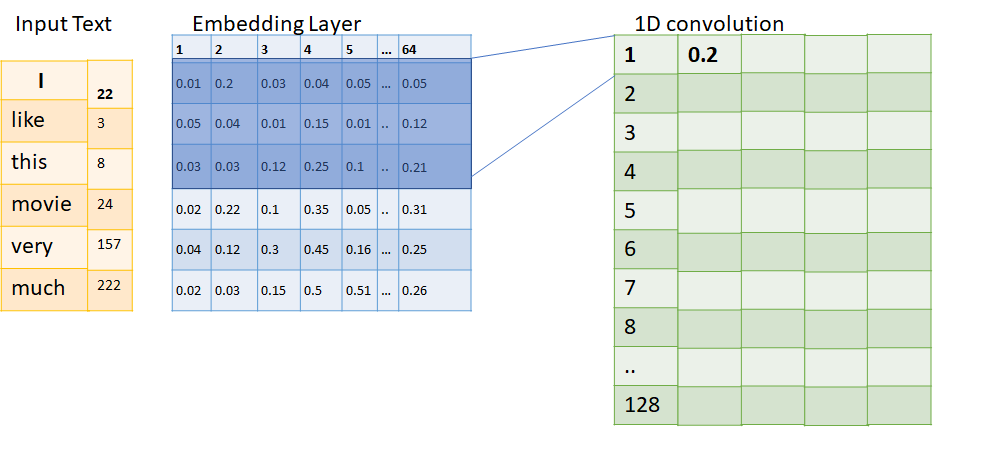

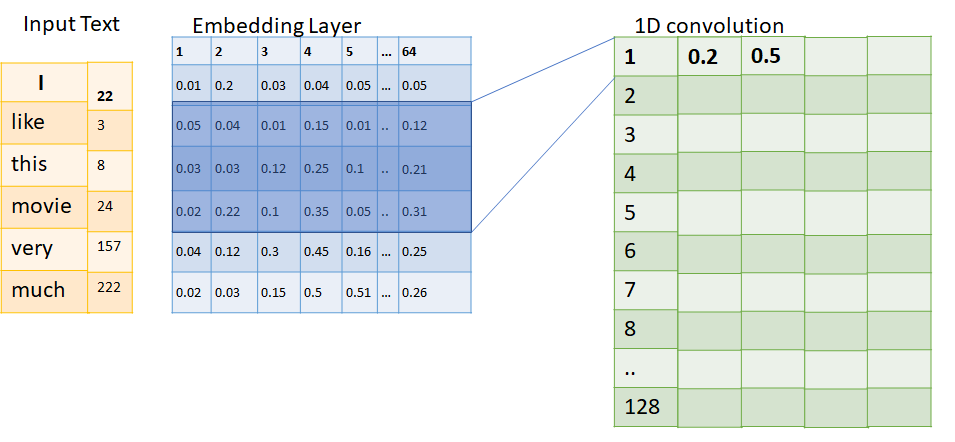

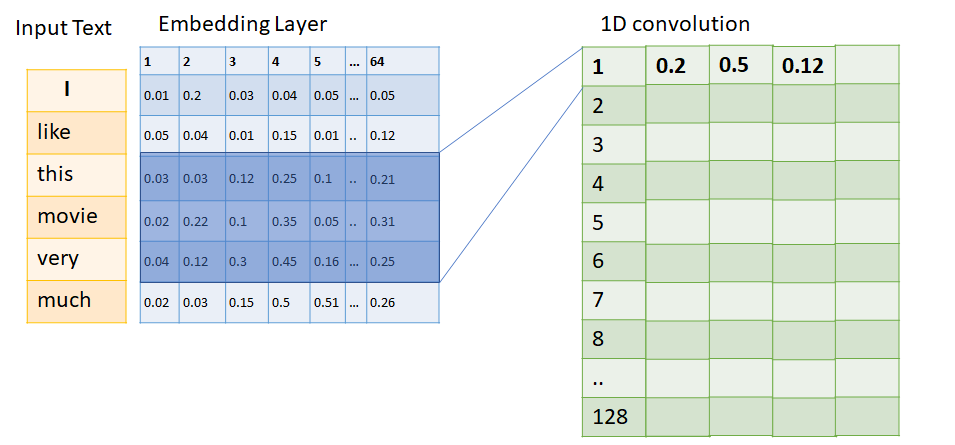

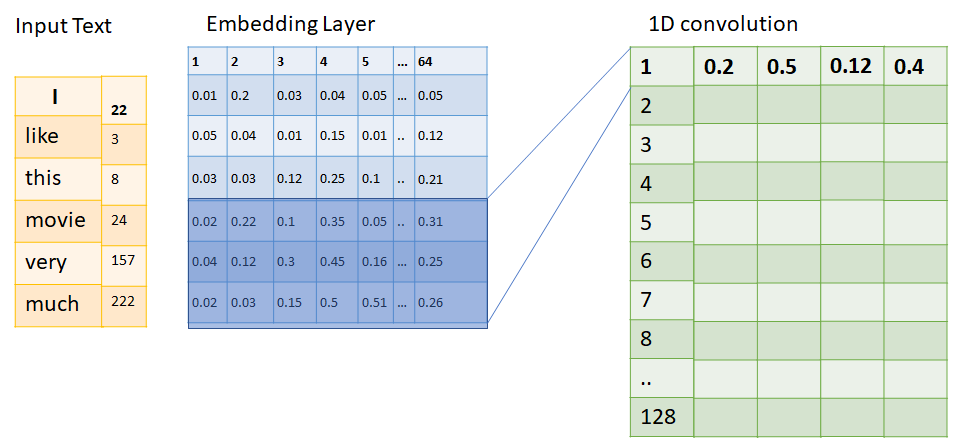

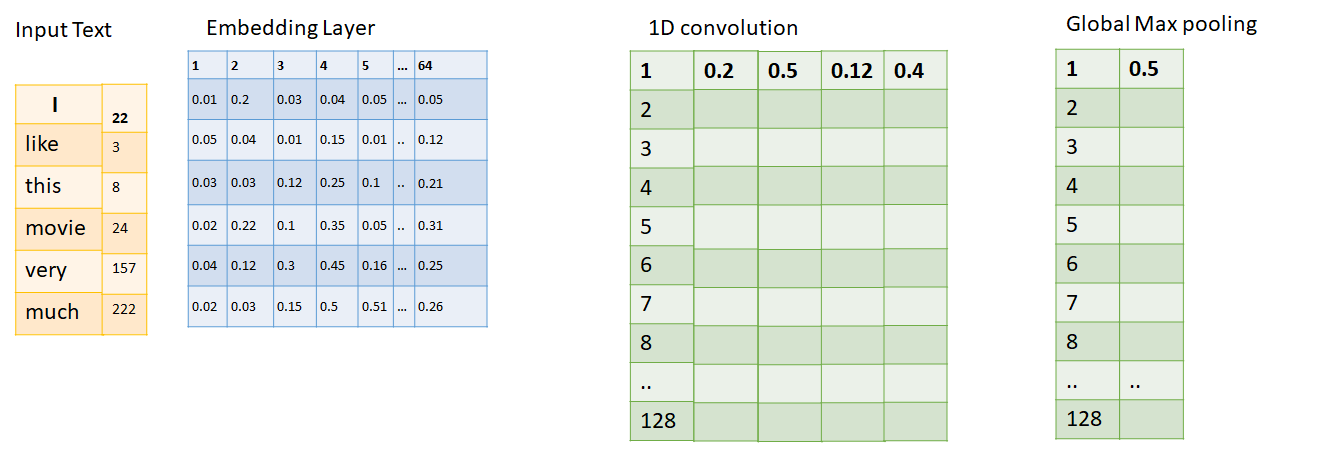

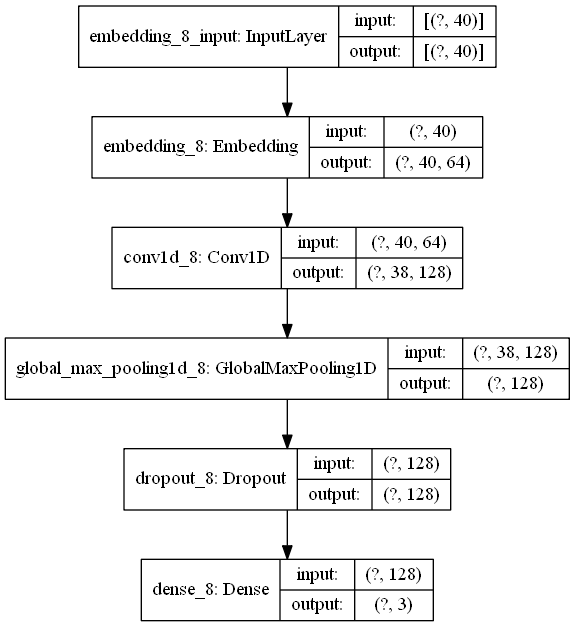

In [35]:
tf.keras.utils.plot_model(model, "multi_input_and_output_model.png", show_shapes=True)

Let's train our model

In [36]:
epochs = 100
# Fit the model using the train and test datasets.
#history = model.fit(x_train, train_labels,validation_data= (x_test,test_labels),epochs=epochs )
history = model.fit(train_ds.shuffle(2000).batch(128),
                    epochs= epochs ,
                    validation_data=valid_ds.batch(128),
                    verbose=1)

Train for 189 steps, validate for 21 steps
Epoch 1/100


d:\tensorflow\tf\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
d:\tensorflow\tf\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


189/189 [==============================] - 10s 54ms/step - loss: 1.1178 - CategoricalAccuracy: 0.4783 - val_loss: 0.9654 - val_CategoricalAccuracy: 0.6435
Epoch 2/100
189/189 [==============================] - 8s 43ms/step - loss: 0.9537 - CategoricalAccuracy: 0.6656 - val_loss: 0.9332 - val_CategoricalAccuracy: 0.6883
Epoch 3/100
189/189 [==============================] - 8s 44ms/step - loss: 0.9367 - CategoricalAccuracy: 0.6937 - val_loss: 0.9288 - val_CategoricalAccuracy: 0.7059
Epoch 4/100
189/189 [==============================] - 8s 44ms/step - loss: 0.9320 - CategoricalAccuracy: 0.7002 - val_loss: 0.9279 - val_CategoricalAccuracy: 0.7138
Epoch 5/100
189/189 [==============================] - 9s 48ms/step - loss: 0.9310 - CategoricalAccuracy: 0.7042 - val_loss: 0.9448 - val_CategoricalAccuracy: 0.7126
Epoch 6/100
189/189 [==============================] - 9s 49ms/step - loss: 0.9305 - CategoricalAccuracy: 0.7080 - val_loss: 0.9335 - val_CategoricalAccuracy: 0.7134
Epoch 7/100
189

189/189 [==============================] - 9s 48ms/step - loss: 0.9131 - CategoricalAccuracy: 0.7419 - val_loss: 0.9374 - val_CategoricalAccuracy: 0.7141
Epoch 100/100
189/189 [==============================] - 9s 47ms/step - loss: 0.9135 - CategoricalAccuracy: 0.7400 - val_loss: 0.9407 - val_CategoricalAccuracy: 0.7126


In [37]:
history.history


{'loss': [1.1184933941157122,
  0.9531030511119315,
  0.937140321618676,
  0.9321290777557057,
  0.9306929732284033,
  0.9297630696384628,
  0.9284770882472304,
  0.9288732166661834,
  0.9282104888812394,
  0.927759382490661,
  0.927945953267895,
  0.9277907699460424,
  0.9255959105998659,
  0.926649411456651,
  0.9256454872756251,
  0.9257315206139523,
  0.9261224003780084,
  0.9238718759084702,
  0.9255811971848857,
  0.9242749989161481,
  0.9244924683589875,
  0.9244851126665292,
  0.9240543796267892,
  0.9244238607391089,
  0.9239372514890147,
  0.9228773908097001,
  0.9235429429477148,
  0.9235735056328603,
  0.9227947121760559,
  0.9232392680765803,
  0.9219240495722483,
  0.9217022830296403,
  0.9212131716916283,
  0.9213633643648003,
  0.9204544241314692,
  0.9216223735115342,
  0.9210897221440868,
  0.9203247021729615,
  0.9202566430663366,
  0.9196080654478287,
  0.9204519045850054,
  0.9196680740851424,
  0.9202468657655997,
  0.9200666908668034,
  0.9193181528128507,
  0.91

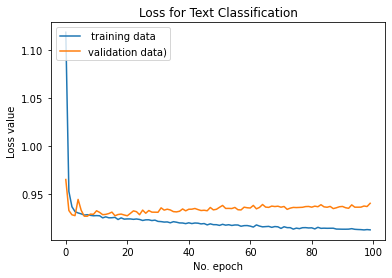

In [38]:

plt.plot(history.history['loss'], label=' training data')
plt.plot(history.history['val_loss'], label='validation data)')
plt.title('Loss for Text Classification')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

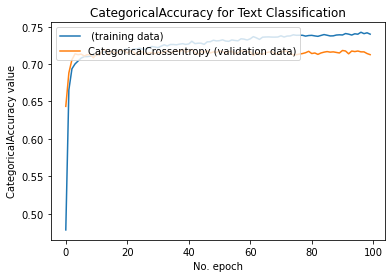

In [39]:


plt.plot(history.history['CategoricalAccuracy'], label=' (training data)')
plt.plot(history.history['val_CategoricalAccuracy'], label='CategoricalCrossentropy (validation data)')
plt.title('CategoricalAccuracy for Text Classification')
plt.ylabel('CategoricalAccuracy value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()


Lets save our model and tokenizer

In [40]:
model.save('C:\\TweetSenitment\\savedTFCNNModel\\tf_cnnmodel') 
json_string = tokenizer.to_json()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: C:\TweetSenitment\savedTFCNNModel\tf_cnnmodel\assets


In [41]:
import json
with open('C:\\TweetSenitment\\savedTFCNNModel\\tokenizer.json', 'w') as outfile:
    json.dump(json_string, outfile)

Lets load our model and test on test data

In [42]:
new_model = tf.keras.models.load_model('C:\\TweetSenitment\\savedTFCNNModel\\tf_cnnmodel')
new_model.summary()


Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 40, 64)            1280064   
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 38, 128)           24704     
_________________________________________________________________
global_max_pooling1d_8 (Glob (None, 128)               0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 3)                 387       
Total params: 1,305,155
Trainable params: 1,305,155
Non-trainable params: 0
_________________________________________________________________


In [43]:
with open('C:\\TweetSenitment\\savedTFCNNModel\\tokenizer.json') as json_file:
    json_string = json.load(json_file)
tokenizer1 = tf.keras.preprocessing.text.tokenizer_from_json(json_string)

In [44]:
x_test  = np.array( tokenizer.texts_to_sequences(test_data['text'].tolist()) )
x_test = pad_sequences(x_test, padding='post', maxlen=40)

d:\tensorflow\tf\lib\site-packages\ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.


In [45]:

# Generate predictions (probabilities -- the output of the last layer)
# on test  data using `predict`
print("Generate predictions for all samples")
predictions = new_model.predict(x_test)
print(predictions)
predict_results = predictions.argmax(axis=1)


Generate predictions for all samples
[[1.4229332e-01 8.9901769e-01 1.8149537e-01]
 [2.7187658e-03 3.2710705e-02 9.8550016e-01]
 [9.5976716e-01 7.5771965e-02 1.0393349e-02]
 ...
 [7.8557450e-01 3.6724645e-01 2.9643273e-02]
 [8.9249731e-04 1.3467870e-02 9.9620050e-01]
 [2.2294002e-03 2.6725024e-02 9.8878294e-01]]


In [46]:
test_data['pred_sentiment']= predict_results
test_data['pred_sentiment'] = np.where((test_data.pred_sentiment == 0),'negative',test_data.pred_sentiment)
test_data['pred_sentiment'] = np.where((test_data.pred_sentiment == '1'),'neutral',test_data.pred_sentiment)
test_data['pred_sentiment'] = np.where((test_data.pred_sentiment == '2'),'positive',test_data.pred_sentiment)

In [47]:
labels = ['positive', 'negative','neutral']
    
print(classification_report(test_data['sentiment'].tolist(),test_data['pred_sentiment'].tolist(),labels=labels))

              precision    recall  f1-score   support

    positive       0.74      0.78      0.76      1075
    negative       0.70      0.68      0.69       983
     neutral       0.68      0.67      0.67      1376

    accuracy                           0.71      3434
   macro avg       0.71      0.71      0.71      3434
weighted avg       0.70      0.71      0.70      3434

